In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Load data
data = pd.read_csv('/Users/britneyjaculina/Desktop/Trihourly_Weather_Dataset.csv')

In [3]:
# Transform 'forest_fire' into binary
data['forest_fire'] = data['forest_fire'].map({'Y': 1, 'N': 0})

In [4]:
# Assuming Severity might be categorical and mapping it
# severity_mapping = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3}
data['Severity'] = data['Severity'].fillna(0)

In [5]:
# Convert 'date' specifying the format explicitly
data['date'] = pd.to_datetime(data['date'], format='%m/%d/%y')  # Adjust format as per your date format
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data.drop('date', axis=1, inplace=True)  # Drop the original date column

In [6]:
# Convert 'time' into hour, minute, second
# Example format '%H:%M:%S' - adjust as needed based on your data
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S').dt.time
data['hour'] = pd.to_datetime(data['time'], format='%H:%M:%S').dt.hour
data['minute'] = pd.to_datetime(data['time'], format='%H:%M:%S').dt.minute
data.drop('time', axis=1, inplace=True)  # Drop the original time column if it's now redundant

In [7]:
data.drop('datetime', axis=1, inplace=True)

In [8]:
# Fill missing values
data.fillna(data.select_dtypes(include=['number']).mean(), inplace=True)

In [9]:
# Count the number of negative samples (forest_fire = 0)
num_negative_samples = (data['forest_fire'] == 0).sum()

print("Number of negative samples (forest_fire = 0):", num_negative_samples)

Number of negative samples (forest_fire = 0): 11688


In [10]:
# Count the number of positive samples (forest_fire = 1)
num_positive_samples = (data['forest_fire'] == 1).sum()

print("Number of positive samples (forest_fire = 1):", num_positive_samples)

Number of positive samples (forest_fire = 1): 6421


In [11]:
# Set up features and target
X = data.drop(['forest_fire','Severity'], axis=1)
y = data['Severity']

In [12]:
X.head()

,temperature_2m,relative_humidity_2m,precipitation,surface_pressure,cloud_cover,wind_speed_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,year,month,day,hour,minute
0,6.061000,67.824059,0.0,933.246216,20.400002,6.638072,6.061,8.061001,0.364,0.372,2020.0,1.0,1.0,7.0,0.0
1,3.861000,77.639603,0.0,931.856018,26.700001,4.693825,5.311,7.761000,0.364,0.372,2020.0,1.0,1.0,9.0,0.0
2,4.361000,75.236038,0.0,931.915161,14.400001,4.610250,3.911,6.961000,0.359,0.370,2020.0,1.0,1.0,12.0,0.0
3,6.111000,73.412125,0.0,932.712647,20.700001,8.788720,4.611,6.511000,0.359,0.369,2020.0,1.0,1.0,15.0,0.0
4,12.561001,61.951244,0.0,934.771851,0.000000,6.489992,7.461,6.511000,0.358,0.369,2020.0,1.0,1.0,18.0,0.0


In [13]:
y.value_counts()

Severity
0.000000     11688
27.500000      156
25.000000       90
36.935283        6
36.614845        5
             ...  
31.585665        1
31.582743        1
31.579553        1
31.573254        1
42.643980        1
Name: count, Length: 5476, dtype: int64

In [14]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier with L1 regularization (Lasso)
# model = XGBClassifier(objective='binary:logistic', learning_rate=0.1, n_estimators=100, seed=42, alpha=1)

# Initialize the XGBoost classifier with L2 regularization (Ridge)
# model = XGBClassifier(objective='binary:logistic', learning_rate=0.1, n_estimators=100, seed=42, reg_lambda=100)

# Initialize the XGBoost regressor
regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the regressor on the training data
regressor.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = regressor.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 2.632527555483956


In [15]:
# Define a function to map the values based on the condition
def classify_severity(severity):
    if severity == 0:
        return 0
    else:
        return 1

# Create the 'classified' column using the 'Severity' column
data['classified'] = data['Severity'].apply(classify_severity)

# Print the updated DataFrame to verify the changes
print(data['classified'])

0        0
1        0
2        0
3        0
4        0
        ..
18105    1
18106    1
18107    1
18108    1
18109    1
Name: classified, Length: 18110, dtype: int64


In [16]:
# Count the number of positive samples (classified = 1)
num_classified = (data['classified'] == 1).sum()

print("Number of positive samples (classified = 1):", num_classified)

Number of positive samples (classified = 1): 6422


In [17]:
# Count the number of positive samples (forest_fire = 1)
num_positive_samples = (data['forest_fire'] == 1).sum()

print("Number of positive samples (forest_fire = 1):", num_positive_samples)

Number of positive samples (forest_fire = 1): 6421


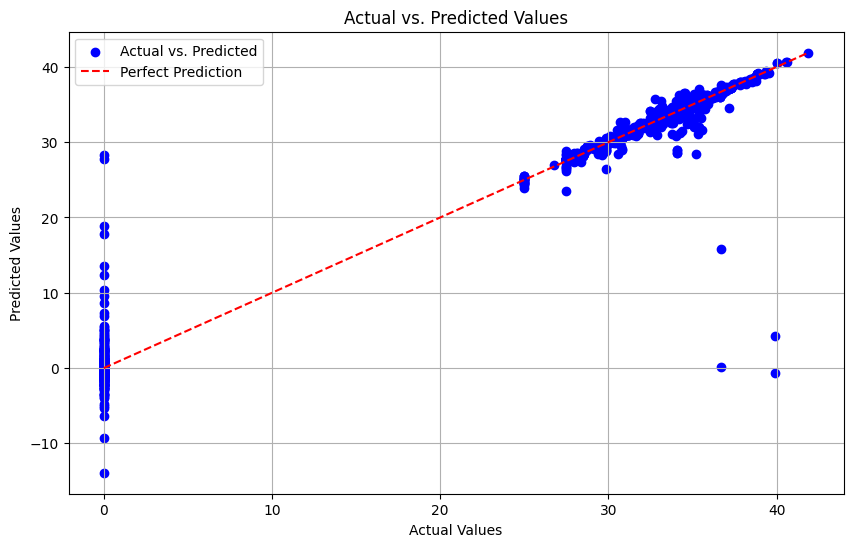

In [18]:
import matplotlib.pyplot as plt

# Plotting actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
